# Variational Autoencoder

### Autoencoder

First, we need to get an idea of whan an autoencoder is. The goal of an autoencoder is to compress data, yet keeping the information describing the data. The autoencoder will implicitly extract the most descriptive components of the data when compressing it, and it is therefore a commonly used component in creative architectures within DL. The idea behind an autoencoder is relatively simple - push raw data (X) through a shrinking pipeline (q) and make the autoencoder network learn what features to remove and what to keep. Push the shrunken data (z) through an increasing sized pipeline (p), and make the autoencoder network learn what features it needs to add to reproduce the raw input.

#### Variational autoencoder

Let's think probability. The joint probability of the model above is:

$$p(X,z) = p (X | z)p(z)$$

According to Bayes: $$p(z | X) = \frac{p(X | z)p(z)}{p(X)}$$

Which can be calculated by marginalizing the latent varables:

$$p(X) = \int p(X | z)p(z)dz $$

Which is hard to calculate, as it requires exponentional computational time over all configurations of the latent variables.

This is why we approximate $p(z | X)$ with a family of distributions $q_{\lambda}(z | X)$, where the variational parameter $\lambda$ represents the family of distributions. To calulate the amount of lost information when approximating $p(z | X)$ using $q(z | X)$, Kullback-Leibler divergence is used (which is impossible to compute directly, hence the use of Evidence Lower BOund.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

from scipy.stats import norm
from torch.autograd import Variable
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import MNIST
from torchvision.utils import make_grid as make_image_grid
from tqdm import trange

torch.manual_seed(2017) # reproducability
sns.set_style('dark')
%matplotlib inline

In [2]:
# Model
class VAE(nn.Module):
    def __init__(self,latent_dim=20,hidden_dim=500):
        super(VAE,self).__init__()
        self.fc_e = nn.Linear(784,hidden_dim)
        self.fc_mean = nn.Linear(hidden_dim,latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim,latent_dim)
        self.fc_d1 = nn.Linear(latent_dim,hidden_dim)
        self.fc_d2 = nn.Linear(hidden_dim,784)
            
    def encoder(self,x_in):
        x = F.relu(self.fc_e(x_in.view(-1,784)))
        mean = self.fc_mean(x)
        logvar = self.fc_logvar(x)
        return mean, logvar
    
    def decoder(self,z):
        z = F.relu(self.fc_d1(z))
        x_out = F.sigmoid(self.fc_d2(z))
        return x_out.view(-1,1,28,28)
    
    def sample_normal(self,mean,logvar):
        # Using torch.normal(means,sds) returns a stochastic tensor which we cannot backpropogate through.
        # Instead we utilize the 'reparameterization trick'.
        # http://dpkingma.com/wordpress/wp-content/uploads/2015/12/talk_nips_workshop_2015.pdf
        sd = torch.exp(logvar*0.5)
        e = Variable(torch.randn(sd.size())) # Sample from standard normal
        z = e.mul(sd).add_(mean)
        return z
    
    def forward(self,x_in):
        z_mean, z_logvar = self.encoder(x_in)
        z = self.sample_normal(z_mean,z_logvar)
        x_out = self.decoder(z)
        return x_out, z_mean, z_logvar

model = VAE()

In [3]:
# Loss function
def criterion(x_out,x_in,z_mu,z_logvar):
    bce_loss = F.binary_cross_entropy(x_out,x_in,size_average=False)
    kld_loss = -0.5 * torch.sum(1 + z_logvar - (z_mu ** 2) - torch.exp(z_logvar))
    loss = (bce_loss + kld_loss) / x_out.size(0) # normalize by batch size
    return loss

In [4]:
def criterion_with_weighted_kl(x_out, x_in, z_mu, z_logvar, kl_weight=1.0):
    # Implement this function by modifying the original VAE loss function.
    # The loss should combine binary cross-entropy (BCE) and a weighted KL divergence term.
    # Use the provided kl_weight parameter to scale the KL divergence before combining.
    # Normalize the total loss by the batch size.
    bce_loss = F.binary_cross_entropy(x_out, x_in, size_average=False)
    kl_loss = -0.5 * kl_weight * torch.mean(1 + z_logvar - z_mu.pow(2) - z_logvar.exp())
    loss = (bce_loss + kl_loss)/x_out.shape[0] # Normalize the total loss by the batch size.
    return loss

In [5]:
# Optimizer
optimizer = torch.optim.Adam(model.parameters())

In [6]:
# Data loaders
trainloader = DataLoader(
    MNIST(root='./data',train=True,download=True,transform=transforms.ToTensor()),
    batch_size=128,shuffle=True)
testloader = DataLoader(
    MNIST(root='./data',train=False,download=True,transform=transforms.ToTensor()),
    batch_size=128,shuffle=True)

dataiter = iter(trainloader)
images, labels = next(dataiter)

100%|██████████| 9.91M/9.91M [00:05<00:00, 1.92MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 257kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.54MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 25.1MB/s]


Epochs:   0%|          | 0/15 [00:00<?, ?it/s]/home/supercomputing/miniconda3/envs/cv/lib/python3.13/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Epochs: 100%|██████████| 15/15 [00:58<00:00,  3.88s/it]


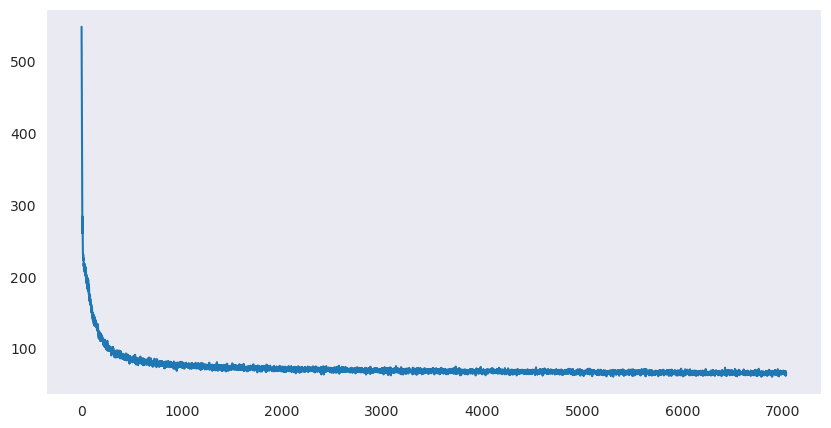

In [8]:
# Training
kl_weight = 1.0
def train(model, optimizer, dataloader, epochs=15):
    losses = []
    for epoch in trange(epochs, desc='Epochs'):
        for images, _ in dataloader:
            x_in = Variable(images)
            optimizer.zero_grad()
            x_out, z_mu, z_logvar = model(x_in)
            loss = criterion_with_weighted_kl(x_out, x_in, z_mu, z_logvar, kl_weight)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
    return losses

train_losses = train(model, optimizer, trainloader)
plt.figure(figsize=(10, 5))
plt.plot(train_losses)
plt.show()

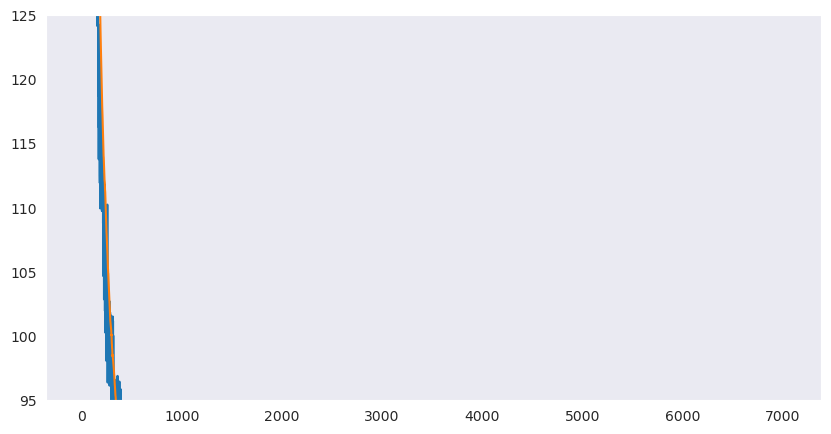

In [9]:
# Visualize moving average of losses
def visualize_losses_moving_average(losses,window=50,boundary='valid',ylim=(95,125)):
    mav_losses = np.convolve(losses,np.ones(window)/window,boundary)
    corrected_mav_losses = np.append(np.full(window-1,np.nan),mav_losses)
    plt.figure(figsize=(10,5))
    plt.plot(losses)
    plt.plot(corrected_mav_losses)
    plt.ylim(ylim)
    plt.show()

visualize_losses_moving_average(train_losses)

In [10]:
# Testing
def test(model, dataloader):
    running_loss = 0.0
    for images, _ in dataloader:
        x_in = Variable(images)
        x_out, z_mu, z_logvar = model(x_in)
        loss = criterion_with_weighted_kl(x_out, x_in, z_mu, z_logvar, kl_weight)
        running_loss = running_loss + (loss.item() * x_in.size(0))  # Korrektur hier
    return running_loss / len(dataloader.dataset)

test_loss = test(model, testloader)
print(test_loss)

65.66328343505859


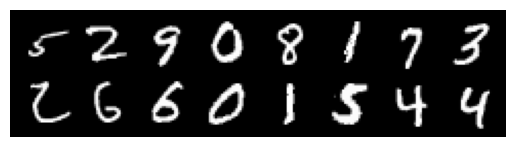

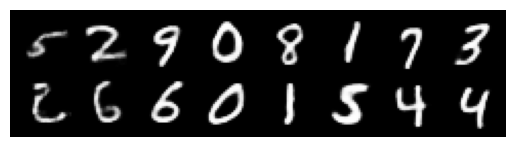

In [11]:
# Visualize VAE input and reconstruction
def visualize_mnist_vae(model, dataloader, num=16):
    def imshow(img):
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.axis('off')
        plt.show()
        
    images, _ = next(iter(dataloader))
    images = images[0:num, :, :]
    x_in = Variable(images)
    x_out, _, _ = model(x_in)
    x_out = x_out.data
    imshow(make_image_grid(images))
    imshow(make_image_grid(x_out))

visualize_mnist_vae(model, testloader)

Epochs: 100%|██████████| 15/15 [01:14<00:00,  4.94s/it]


143.82024431152342


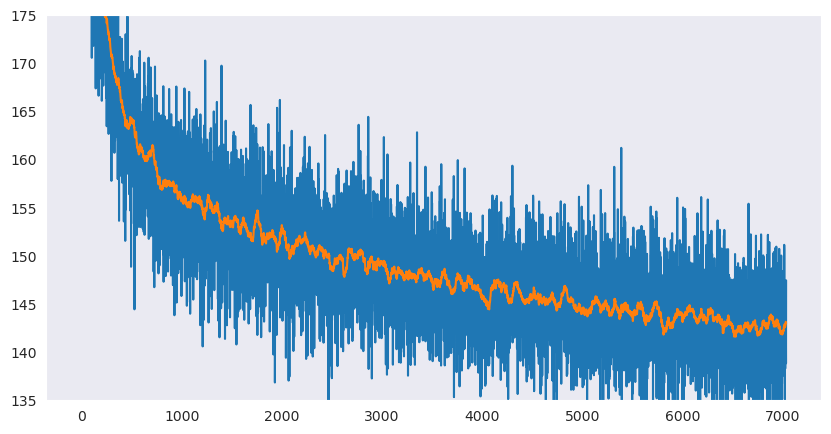

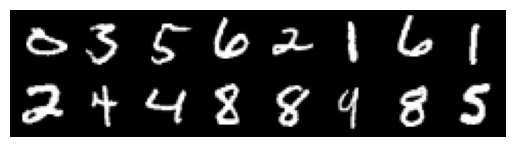

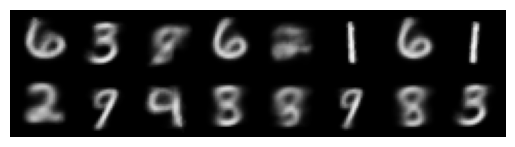

In [12]:
# Train, test and visualize reconstruction using a 2D latent space
model2 = VAE(latent_dim=2)
optimizer2 = torch.optim.Adam(model2.parameters())

train2_losses = train(model2,optimizer2,trainloader)
test2_loss = test(model2,testloader)

print(test2_loss)
visualize_losses_moving_average(train2_losses,ylim=(135,175))
visualize_mnist_vae(model2,testloader)

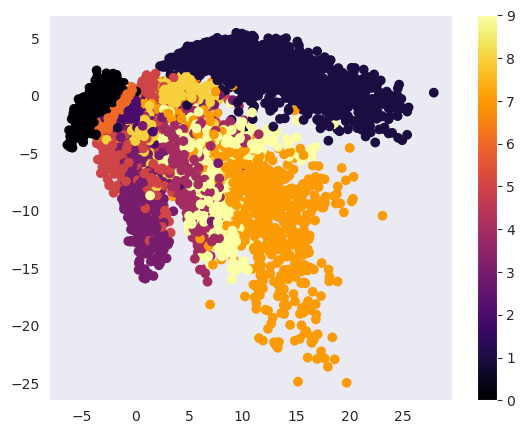

In [13]:
# Visualize test data encodings on the latent space
def visualize_encoder(model,dataloader):
    z_means_x, z_means_y, all_labels = [], [], []
    
    for images,labels in iter(dataloader):
        z_means,_ = model.encoder(Variable(images))
        z_means_x = np.append(z_means_x,z_means[:,0].data.numpy())
        z_means_y = np.append(z_means_y,z_means[:,1].data.numpy())
        all_labels = np.append(all_labels,labels.numpy())
        
    plt.figure(figsize=(6.5,5))
    plt.scatter(z_means_x,z_means_y,c=all_labels,cmap='inferno')
    plt.colorbar()
    plt.show()

visualize_encoder(model2,testloader)

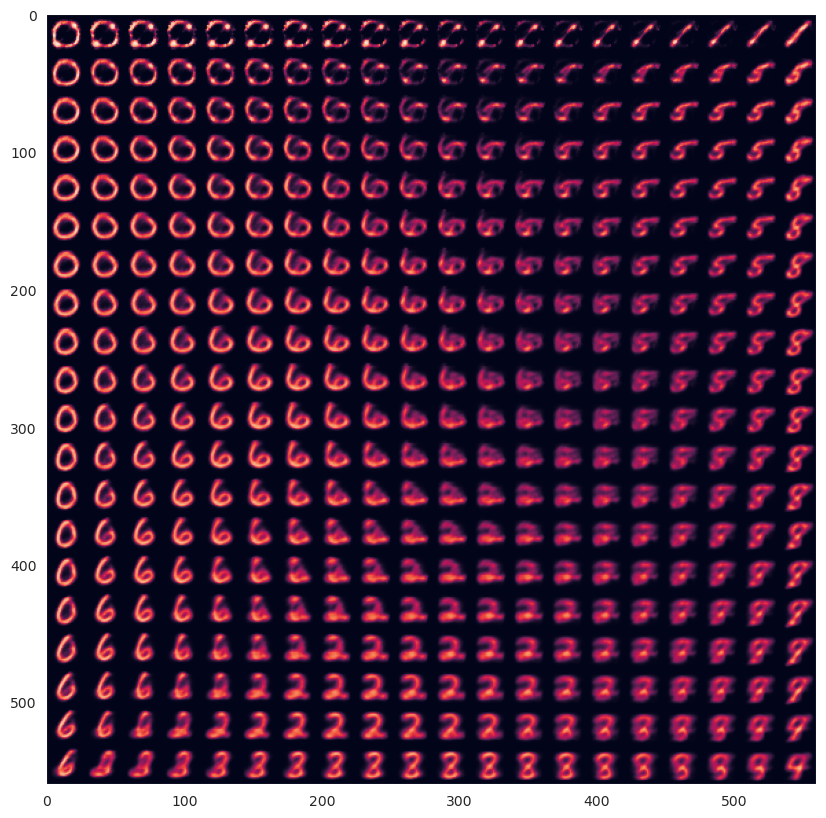

In [14]:
# Visualize digits generated from latent space grid
def visualize_decoder(model,num=20,range_type='g'):
    image_grid = np.zeros([num*28,num*28])

    if range_type == 'l': # linear range
        # corresponds to output range of visualize_encoding()
        range_space = np.linspace(-4,4,num)
    elif range_type == 'g': # gaussian range
        range_space = norm.ppf(np.linspace(0.01,0.99,num))
    else:
        range_space = range_type

    for i, x in enumerate(range_space):
        for j, y in enumerate(reversed(range_space)):
            z = Variable(torch.FloatTensor([[x,y]]))
            image = model.decoder(z)
            image = image.data.numpy()
            image_grid[(j*28):((j+1)*28),(i*28):((i+1)*28)] = image

    plt.figure(figsize=(10, 10))
    plt.imshow(image_grid)
    plt.show()

visualize_decoder(model2)

# Refernces
- Kingma, Diederik P. and Max Welling. “Auto-Encoding Variational Bayes.” CoRR abs/1312.6114 (2013): n. pag.